In [ ]:
# To download kssl dataset
# cd /root
# python
# import gdown
# id = "1qh8isMQIzhArsj3RNWJe6g0lx_cs7iBG"
# gdown.download(id=id)
# quit()
# tar -xvf kssl.tar.gz

In [2]:
!pip install gdown 
!pip install --upgrade gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.5.1
    Uninstalling gdown-4.5.1:
      Successfully uninstalled gdown-4.5.1


In [1]:
!pip install spanda

  Preparing metadata (setup.py) ... done
  Created wheel for brukeropusreader: filename=brukeropusreader-1.3.4-py3-none-any.whl size=5311 sha256=efdf83a6505b1c6f80eb39e4ae5e53b35fd70beecf4b437f8bedecb3f3a5f307
  Stored in directory: /root/.cache/pip/wheels/6a/0d/86/91cddedf53ade4d06446f0efb197520a25ccc18b6725c65378
Successfully built brukeropusreader


In [3]:
from pathlib import Path
from fastai.vision.all import *
from fastai.data.all import *
from spanda.data.transforms.kssl import (get_spectra_files, to_spectra, rand_w_avg, AnalytesTfm)
from fastcore.parallel import parallel

use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

In [4]:
path = Path('/root/kssl-mirs')
analyte = 723 # CEC

In [5]:
path.ls()

(#44101) [Path('/root/kssl-mirs/174608'),Path('/root/kssl-mirs/174916'),Path('/root/kssl-mirs/19897'),Path('/root/kssl-mirs/68409'),Path('/root/kssl-mirs/86746'),Path('/root/kssl-mirs/172147'),Path('/root/kssl-mirs/180551'),Path('/root/kssl-mirs/113720'),Path('/root/kssl-mirs/25251'),Path('/root/kssl-mirs/176480')...]

In [6]:
def is_valid(path):
    is_analyte_pos = AnalytesTfm(analytes=[analyte])(path).item() > 0
    has_spectra = len(get_spectra_files(path)) > 0
    return is_analyte_pos and has_spectra

In [7]:
%%time 
mask = parallel(is_valid, path.ls(), n_workers=8, progress=True)
paths = path.ls()[mask]

CPU times: user 17.7 s, sys: 3.71 s, total: 21.4 s
Wall time: 2min 31s


In [8]:
class Spectra(Tensor): 
    def show(self, ctx=None, figsize=(12,4), **kwargs):
        spectra = self
        if ctx is None: _,ctx = plt.subplots(figsize=figsize)
        wn = np.arange(4000, 600, -2)
        #ctx.imshow(im, **{**self._show_args, **kwargs})
        ctx.set_xlim(np.max(wn), np.min(wn))
        ctx.set(xlabel='Wavenumber', ylabel='Absorbance')
        ctx.set_axisbelow(True)
        for spectrum in spectra:
            _ = ctx.plot(wn, spectrum, c='steelblue', lw=0.5)
        ctx.grid(True, which='both')
        return ctx

@Transform
def snv(x: Spectra, # Spectrum 
       ) -> Spectra: # Standard Normal Variate of spectrum
    "Standard Normal Variate Transform of input spectrum"
    mean, std = torch.mean(x), torch.std(x)
    return (x - mean)/std

In [9]:
x_tfms = [get_spectra_files, to_spectra, rand_w_avg, snv]
y_tfms = [AnalytesTfm(analytes=[analyte])]

In [10]:
splits = RandomSplitter(seed=42)(paths)
dsets = Datasets(paths, [x_tfms, y_tfms], splits=splits)
dls = dsets.dataloaders(bs=16, num_workers=8, drop_last=True)
dls.train.one_batch()[0].shape

torch.Size([16, 1, 1700])

In [18]:
model = xresnet18(ndim=1, c_in=1, ks=3, n_out=1).to(device)
x = dls.train.one_batch()[0]
#model(x)

In [19]:
learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=R2Score())

SuggestedLRs(valley=0.0063095735386013985)

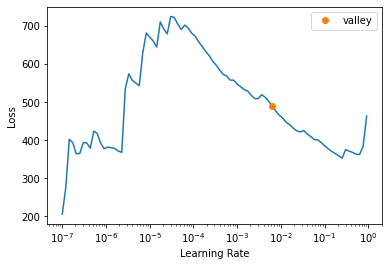

In [13]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(40, 1e-3)

epoch,train_loss,valid_loss,r2_score,time
0,359.560059,106.676987,0.613065,02:04
1,81.228485,92.135262,0.665810,02:04
2,56.532860,53.095028,0.807415,02:05
3,37.778294,46.273178,0.832159,01:58
4,40.973030,51.676704,0.812560,02:02
5,34.503368,46.981564,0.829590,02:02
6,30.758438,534.004150,-0.936923,02:08
7,29.601786,43.086666,0.843717,02:13
8,23.384838,42.746567,0.844951,02:03
9,32.458992,14906.833008,-53.069614,02:02


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
learn.save('xresnet18-cec')